In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [2]:
data_dir= r'C:\Users\Benyamin\Downloads\DATASET\four-shapes\shapes\star' 

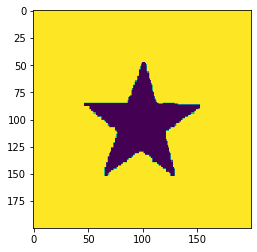

In [3]:
for img in os.listdir(data_dir):        
    img_array=cv2.imread(os.path.join(data_dir,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array) 
    break  
  
    


In [4]:
print(img_array)
img_array.shape

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


(200, 200)

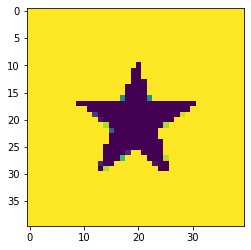

In [5]:
new_array=cv2.resize(img_array,(40,40)) 
plt.imshow(new_array)

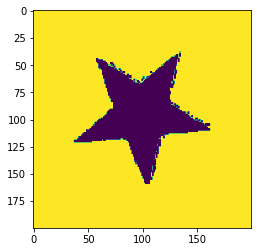

In [6]:
train=[]

def create_training_data():
    for img in os.listdir(data_dir):
        img_array=cv2.imread(os.path.join(data_dir,img), cv2.IMREAD_GRAYSCALE)
        new_array=cv2.resize(img_array,(40,40))
        train.append(new_array)
        plt.imshow(img_array) 
          

create_training_data()

In [7]:
print(len(train))

3765


In [8]:
X_train=[]
for features in train:  
    X_train.append(features)



In [9]:
X_train[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [10]:
X_train = np.array(X_train)/255
print(X_train.shape)
print(X_train[0].shape)

(3765, 40, 40)
(40, 40)


In [11]:
print(X_train.min())
print(X_train.max())

0.0
1.0


In [12]:
X_train =X_train.reshape(-1, 40, 40, 1) * 2. - 1.
print(X_train.shape)
print(X_train[0].shape)

(3765, 40, 40, 1)
(40, 40, 1)


In [13]:
print(X_train.min())
print(X_train.max())

-1.0
1.0


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose 
from tensorflow.keras.models import Sequential


In [15]:
np.random.seed(101)
tf.random.set_seed(101)

In [16]:
codings_size = 300
img_shape=(40,40,1)

In [17]:
generator = Sequential()
generator.add(Dense(10* 10 * 256, input_shape=[codings_size]))
generator.add(Reshape([10, 10, 256]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same',
                              activation="relu"))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                 activation="tanh"))

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=1, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=img_shape))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

GAN = Sequential([generator, discriminator])

In [18]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [19]:
GAN.layers
GAN.summary()
GAN.layers[0].summary()
GAN.layers[1].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 40, 40, 1)         8076801   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 256769    
Total params: 8,333,570
Trainable params: 8,075,905
Non-trainable params: 257,665
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25600)             7705600   
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 256)       1024      
__________________

In [25]:
import tensorflow as tf
batch_size = 32
my_data = X_train
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)       
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)    

In [27]:
generator, discriminator = GAN.layers

epochs = 10

# For every epochs
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%10 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size]) 
        
        # Generate numbers based just on noise input 
        gen_images = generator(noise)  #buat fake image dari ngerandom angka
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0) #satuin input; data palsu+asli di concat
        
        # Targets set to zero for fake images and 1 for real images (labels)
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #buat label scr manual krn buat kasih tau discriminator mana asli, mana palsu (sesuai urutan concat)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            


Currently on Epoch 1
	Currently on batch number 10 of 117
	Currently on batch number 20 of 117
	Currently on batch number 30 of 117
	Currently on batch number 40 of 117
	Currently on batch number 50 of 117
	Currently on batch number 60 of 117
	Currently on batch number 70 of 117
	Currently on batch number 80 of 117
	Currently on batch number 90 of 117
	Currently on batch number 100 of 117
	Currently on batch number 110 of 117
Currently on Epoch 2
	Currently on batch number 10 of 117
	Currently on batch number 20 of 117
	Currently on batch number 30 of 117
	Currently on batch number 40 of 117
	Currently on batch number 50 of 117
	Currently on batch number 60 of 117
	Currently on batch number 70 of 117
	Currently on batch number 80 of 117
	Currently on batch number 90 of 117
	Currently on batch number 100 of 117
	Currently on batch number 110 of 117
Currently on Epoch 3
	Currently on batch number 10 of 117
	Currently on batch number 20 of 117
	Currently on batch number 30 of 117
	Current

In [36]:
from tensorflow.keras.models import load_model #save trained model
generator.save('generator.h5') 
discriminator.save('discriminator.h5') 

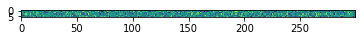

In [43]:
noise = tf.random.normal(shape=[6, codings_size]) #create 6 random inputs
plt.imshow(noise)



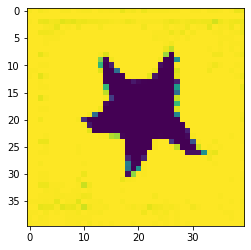

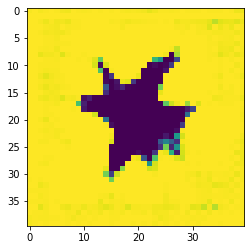

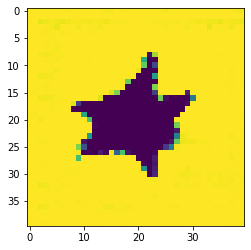

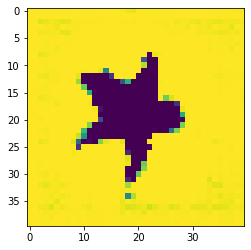

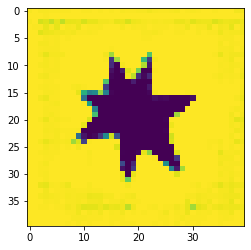

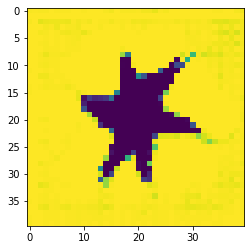

In [47]:
images = generator(noise) #put 6 random inputs to generator

for image in images:     #show the 6 outputs (stars) from trained generator
    plt.imshow(image.numpy().reshape(40,40))
    plt.show()